In [1]:
import ase.io
import os
import requests
from mace.calculators import mace_off, mace_mp
import random
import numpy as np
from tqdm.auto import tqdm
import chemiscope

Install MACE

In [ ]:
! pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118
! pip install mace-torch

Download a dataset of organic crystals from the materials cloud database

In [8]:
filename = "all_crystals.xyz"
if not os.path.exists(filename):
    url = f"https://archive.materialscloud.org/record/file?record_id=1600&filename={filename}"
    response = requests.get(url)
    response.raise_for_status()
    with open(filename, "wb") as f:
        f.write(response.content)

### Import chemical structures

In [ ]:
def chemiscope_auto(
    frames,
    descriptor="mace-off",
    reduce="pca",
    descriptor_opt=None,
    reduce_opt=None,
):

    descriptors = []

    # use mace-off
    if descriptor == "mace-off":

        try:
            from mace.calculators import mace_off
        except ImportError:
            raise ImportError(
                "mace off is not installed.\
                              Please install it using `pip install mace`"
            )

        if descriptor_opt is None:
            descriptor_opt = {"model": "small", "device": "cpu"}

        calculator = mace_off(**descriptor_opt)

    # use mace mp0
    elif descriptor == "mace-mp0":

        try:
            from mace.calculators import mace_mp

        except ImportError:
            raise ImportError(
                "mace mp is not installed.\
                              Please install it using `pip install mace`"
            )

        if descriptor_opt is None:
            descriptor_opt = {"model": "small", "device": "cpu"}

        calculator = mace_mp(**descriptor_opt)

    # use rascaline
    elif descriptor == "rascaline":
        if descriptor_opt is None:
            descriptor_opt = {"cutoff": 6.0, "max_radial": 6, "max_angular": 6}

        raise NotImplementedError("Not implemented yet")

    else:
        raise ValueError(f"Unknown descriptor {descriptor}")

    if descriptor in ["mace-off", "mace-mp0"]:
        for frame in tqdm(frames):
            descriptors.append(calculator.calculate(frame))
        descriptors = np.array(descriptors)

    if reduce == "pca":
        try:
            from sklearn.decomposition import PCA
        except ImportError:
            raise ImportError(
                "sklearn is not installed.\
                              Please install it using `pip install scikit-learn`"
            )

        if reduce_opt is None:
            reduce_opt = {"n_components": 3}
        reducer = PCA(**reduce_opt)

    elif reduce == "umap":
        try:
            from umap import UMAP
        except ImportError:
            raise ImportError(
                "umap is not installed.\
                              Please install it using `pip install umap-learn`"
            )

        if reduce_opt is None:
            reduce_opt = {"n_components": 3}
        reducer = UMAP(**reduce_opt)

    elif reduce == "tsne":
        try:
            from sklearn.manifold import TSNE
        except ImportError:
            raise ImportError(
                "sklearn is not installed.\
                              Please install it using `pip install scikit-learn`"
            )

        if reduce_opt is None:
            reduce_opt = {"n_components": 3}
        reducer = TSNE(**reduce_opt)

    else:
        raise ValueError(f"Unknown reducer {reduce}")

    reduced = reducer.fit_transform(calculator.transform(frames))
    properties = {"reduced_dimension": reduced}

    return chemiscope.show(frames, properties)

In [43]:
frames = ase.io.read("all_crystals.xyz", ":")
random.shuffle(frames)

In [46]:
calc = mace_off(model="small", device="cpu")

Using MACE-OFF23 MODEL for MACECalculator with /Users/matthiaskellner/.cache/mace/MACE-OFF23_small.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


In [47]:
descriptors = []

for frame in tqdm(frames):
    structure_avg = np.mean(calc.get_descriptors(frame, invariants_only=True), axis=0)
    descriptors.append(structure_avg)

descriptors = np.array(descriptors)

  0%|          | 0/2707 [00:00<?, ?it/s]

In [68]:
descriptors.shape

(2707, 192)

In [69]:
np.save("./data/descriptors_MACE_OFF_small.npy", descriptors)

In [49]:
from sklearn.decomposition import PCA

In [50]:
X_pca = PCA(n_components=2).fit_transform(descriptors)

In [70]:
X_pca.shape

(2707, 2)

In [51]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'PCA 2')

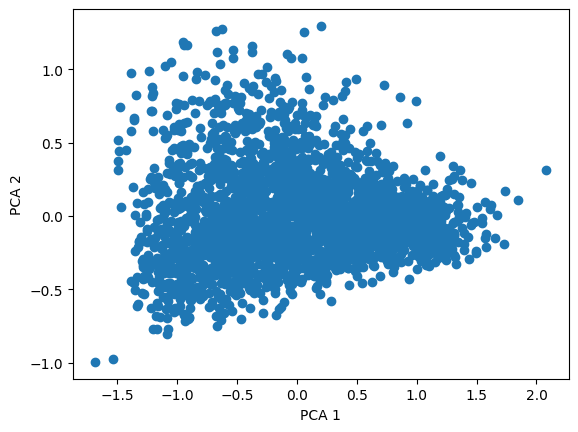

In [52]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

Text(0, 0.5, 'PCA 2')

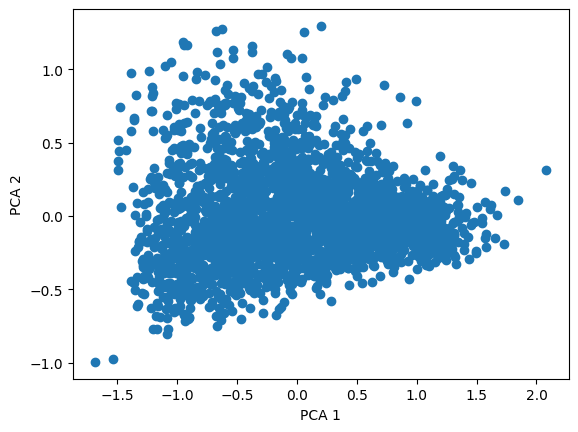

In [53]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

In [71]:
import chemiscope
from sklearn.manifold import TSNE

In [55]:
import umap

In [56]:
reducer = umap.UMAP()

In [57]:
embedding = reducer.fit_transform(descriptors)

In [72]:
X_tsne = TSNE(n_components=2).fit_transform(descriptors)

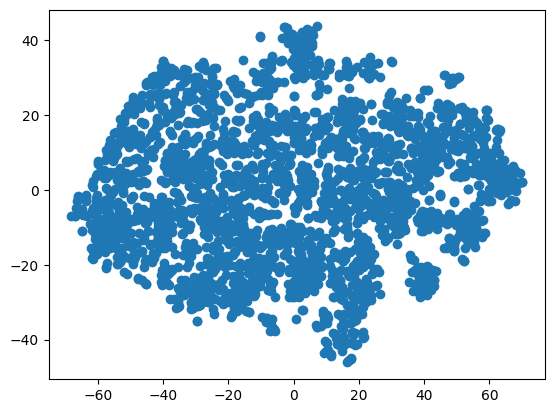

In [73]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

Text(0, 0.5, 'PCA 2')

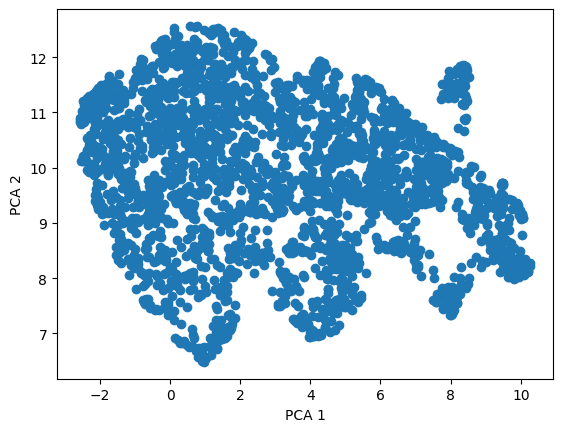

In [59]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

In [82]:
properties = {
    "UMAP": embedding,
    "TSNE": X_tsne,
    "PCA": X_pca,
    "E_cohesive": np.array(
        [
            frame.info["dft_cohesive_energy_relaxed_configs_ryd"] / len(frame)
            for frame in frames
        ]
    ),
}
chemiscope.show(frames, properties)

In [83]:
chemiscope.show(frames, properties)

/opt/anaconda3/envs/chemiscope_auto/lib/python3.11/site-packages/chemiscope/structures/_ase.py:90: UserWarning: the following structure properties properties are only defined for a subset of frames: ['energy']; they will be ignored
  warnings.warn(


<ChemiscopeWidget(meta={'name': ' '}, structures=[{'size': 72, 'names': ['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S…